<a href="https://colab.research.google.com/github/Muhammad-Fauzan-Alfariz/Intel_Image_Classification/blob/main/Fashion%20Apparel%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install -U efficientnet

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD

from keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from random import randint
import cv2 as cv
import plotly.graph_objs as go
import numpy as np
import zipfile
import os
import re, shutil 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls "/content/drive/My Drive"

 apparel_image_datasets.zip  'Fashion Apparel Classificatio.ipynb'
 AXIS-WD346_V1.jpg


In [5]:
# Ekstraksi file zip
local_zip = '/content/drive/MyDrive/apparel_image_datasets.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/MyDrive/apparel-image-dataset')
zip_ref.close()

In [6]:
data_dir = '/content/drive/MyDrive/apparel-image-dataset'
print(os.listdir(data_dir))

['black_dress', 'black_pants', 'black_shirt', 'black_shoes', 'black_shorts', 'blue_dress', 'blue_pants', 'blue_shirt', 'blue_shoes', 'blue_shorts', 'brown_pants', 'brown_shoes', 'brown_shorts', 'green_pants', 'green_shirt', 'green_shoes', 'green_shorts', 'red_dress', 'red_pants', 'red_shoes', 'white_dress', 'white_pants', 'white_shoes', 'white_shorts']


In [7]:
# Buat direktori baru
new_dir = '/content/drive/MyDrive/apparel-images-dataset-category_only'
os.mkdir(new_dir)  # Buat direktori kategori gambar

In [8]:
# Kelompokkan gambar pada direktori kategori
for folder_dir in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_dir)
        label_dir = re.findall(r'\w+\_\w+', folder_path)
        label_dir = label_dir[0].split('_')[1]
        label_dir = os.path.join(new_dir, label_dir)
       
        if not os.path.isdir(label_dir):
          os.mkdir(label_dir)
            

        for image in os.listdir(folder_path):
            path_to_img = os.path.join(folder_path, image)
            label = re.findall(r'\w+\_\w+', path_to_img)
            label = label[0].split('_')[1]
            dest_dir = os.path.join(new_dir, label)
            shutil.move(path_to_img,dest_dir)

In [9]:
image_count = []

def image(new_dir,total_image):
 # perulangan untuk categori dalam os.listdir(new_dir)
 for category in os.listdir(new_dir):
   # gabungkan data new dir(origin) dengan os.listdir(new_dir)
   img_dir = os.path.join(new_dir, category)
   # banyak data file gambar tiap list di img_dir
   img = len(os.listdir(img_dir))
   # Tampung gambar
   image_count.append(img)
   total_image += img
   print(f"{category} : {img}")
 print("Total Image : ", total_image)

image(new_dir,total_image = 0)

dress : 2570
pants : 2789
shirt : 1686
shoes : 3418
shorts : 922
Total Image :  11385


In [10]:
print(os.listdir(new_dir))

['dress', 'pants', 'shirt', 'shoes', 'shorts']


In [11]:
# create trace1 
folder_count = os.listdir(new_dir)
image_apparel = np.arange(len(folder_count))

trace1 = go.Bar(
                x = folder_count,
                y = image_count,
                marker = dict(color = 'rgba(113, 246, 18, 0.4)',
                             line   = dict(color='rgb(79,139,135)',
                             width = 1)),
                text = folder_count)


data = [trace1]
layout = go.Layout(barmode = "group",
                   title = 'Apparel Category',
                   width=600,
                   height=500,
                   paper_bgcolor="lightsteelblue")

fig = go.Figure(data = data, 
                layout = layout)
fig.show()

In [12]:
# Pisahkan atribut dan label
def get_images(directory):
    Images  = []  # List gambar
    Labels  = []  # List kategori gambar
    label   = 0

    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'shirt': #Folder contain Glacier Images get the '2' class label.
            label = 2
        elif labels == 'shoes':
            label = 4
        elif labels == 'dress':
            label = 0
        elif labels == 'pants':
            label = 1
        elif labels == 'shorts':
            label = 3
        
        
        for image_file in os.listdir(directory + labels):
            image_folder = os.path.join(directory + labels + r'/' + image_file)
            image = cv.imread(image_folder)
            image = cv.resize(image, (75,75))
            Images.append(image)
            Labels.append(labels)

    return shuffle(Images, Labels, random_state = 817328462)

# def get_classlabel(class_code):
#   labels = {2:'shirt', 4:'shoes',0:'dress',1:'pants',3:'shorts'}
#   return labels[class_code]         
        

In [13]:
Images, Labels = get_images('/content/drive/MyDrive/apparel-images-dataset-category_only/')

Images = np.array(Images)
Labels = np.array(Labels)

In [14]:
# before labelBinarizer
print("Shape of Images:",Images.shape)
print("Shape of Labels:",Labels.shape)

Shape of Images: (11385, 75, 75, 3)
Shape of Labels: (11385,)


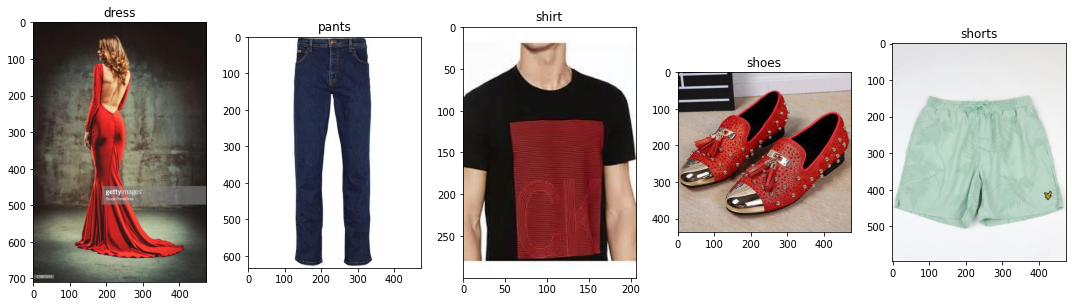

In [15]:
# Tampilkan sampel gambar per folder
fig = plt.figure(figsize = (15,5))
ax = []
i = 1

for image in os.listdir(new_dir):
    ax.append(fig.add_subplot(1,5,i))
    i += 1
    ax[-1].set_title(str(image))
    image_folder = os.path.join(new_dir, image)
    rnd_number = randint(0, len(os.listdir(image_folder)))
    image_file = os.listdir(image_folder)[rnd_number]
    image_file = os.path.join(image_folder, image_file)
    image_show = mpimg.imread(image_file)
    plt.imshow(image_show)

fig.tight_layout()
plt.show()

In [16]:
lb_category = LabelBinarizer()
Labels = lb_category.fit_transform(Labels)

In [17]:
# after labelBinarizer
print("Shape of Images:",Images.shape)
print("Shape of Labels:",Labels.shape)

Shape of Images: (11385, 75, 75, 3)
Shape of Labels: (11385, 5)


In [18]:
label_classes = lb_category.classes_.astype('object')
label_classes

array(['dress', 'pants', 'shirt', 'shoes', 'shorts'], dtype=object)

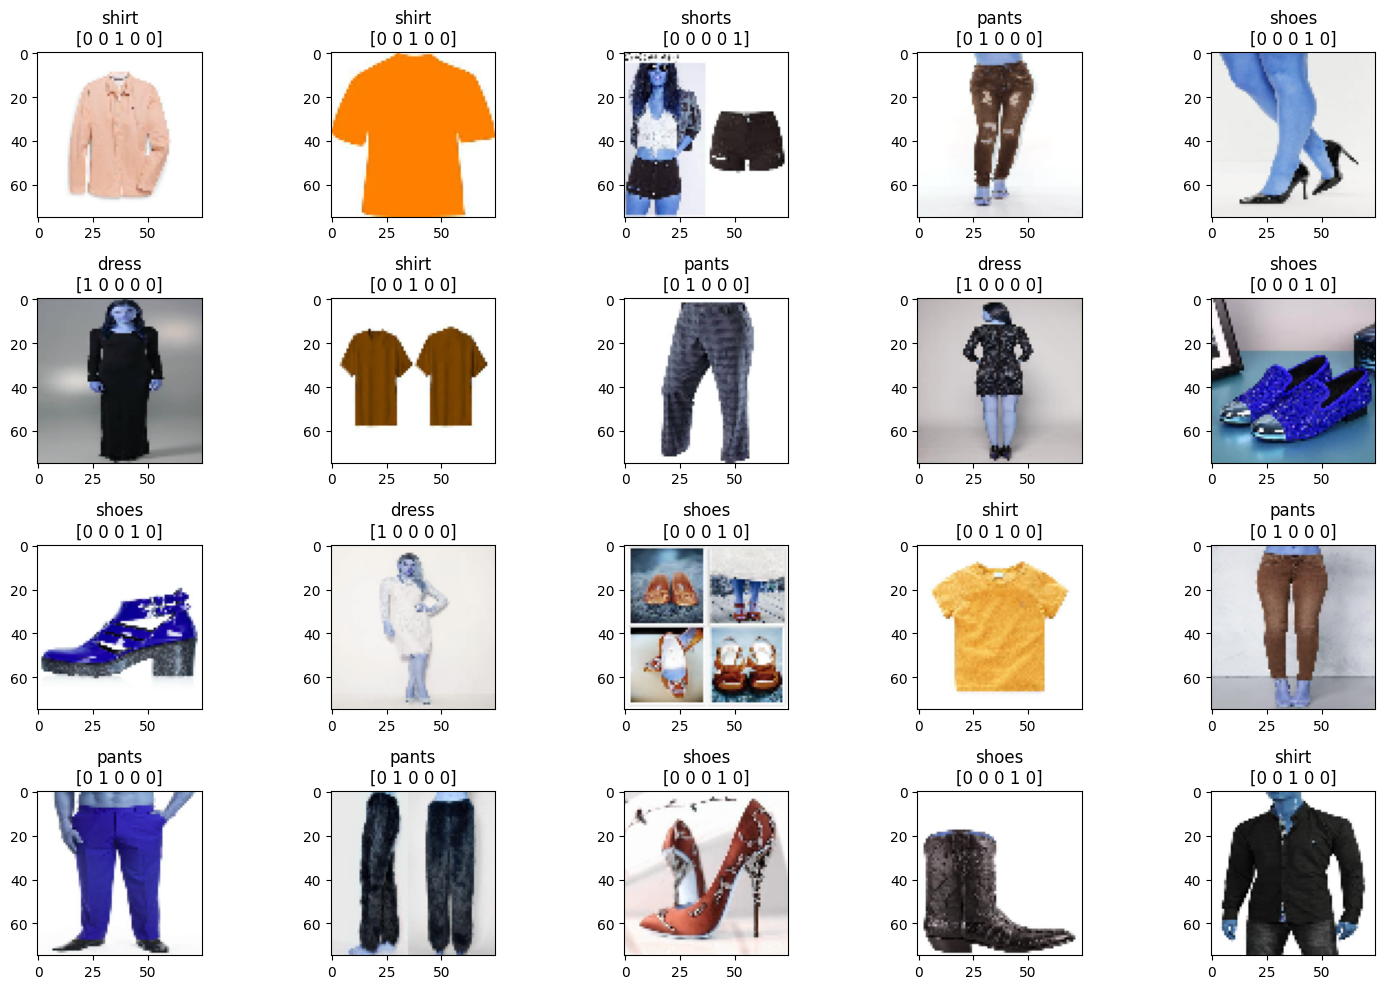

In [19]:
fig = plt.figure(figsize=(15,10),dpi = 100)
ax = []
for i in range(20):
    rnd_number = randint(0,len(Images))
    ax.append(fig.add_subplot(4, 5, i+1))
    bin_class = Labels[rnd_number]
    lab_class = label_classes[np.argmax(Labels[rnd_number])]
    title = f'{lab_class}\n{bin_class}'
    ax[-1].set_title(title)
    plt.imshow(Images[rnd_number])

fig.tight_layout()    
plt.show()

In [20]:
# Bagi train set dan test set
from sklearn.model_selection import train_test_split

X_img, X_imgtest, Y_label, Y_labeltest = train_test_split(Images, Labels, test_size = 0.2)

In [21]:
print(X_img.shape, Y_label.shape)
print(X_imgtest.shape, Y_labeltest.shape)

(9108, 75, 75, 3) (9108, 5)
(2277, 75, 75, 3) (2277, 5)


In [22]:
img_datagen = ImageDataGenerator(rescale =1./255, 
                                 horizontal_flip = True, 
                                 height_shift_range = 0.2, 
                                 width_shift_range = 0.2,
                                 zoom_range = 0.2, 
                                 shear_range = 0.2,
                                 rotation_range = 45,
                                 fill_mode = 'nearest', 
                                 validation_split = 0.2)

train_generator   = img_datagen.flow(X_img, 
                                     Y_label,
                                     shuffle=True,)

validation_generator = img_datagen.flow(X_img, 
                                        Y_label, 
                                        subset='validation',
                                        shuffle=False)

In [23]:
from tensorflow.keras import models, layers
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,ReduceLROnPlateau,LearningRateScheduler

def ConvBlock(model, filters, layers,name):
    for i in range(layers):
        model.add(Conv2D(filters, (3,3), padding = 'same',activation='relu',name=name))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

def create_model():
    model = Sequential()
    model.add(Lambda(lambda x: x, input_shape=(75, 75, 3)))
    ConvBlock(model, 64,  1,'block_1')
    ConvBlock(model, 128, 1,'block_2')
    ConvBlock(model, 256, 1,'block_3')
    ConvBlock(model, 512, 1,'block_4')
    ConvBlock(model, 512, 1,'block_5')
    model.add(Flatten())
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5,activation='softmax'))
    return model 

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 75, 75, 3)         0         
_________________________________________________________________
block_1 (Conv2D)             (None, 75, 75, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 64)        0         
_________________________________________________________________
block_2 (Conv2D)             (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
block_3 (Conv2D)             (None, 18, 18, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 256)         0

In [24]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      print("\nAkurasi model > 92% !!")
      self.model.stop_training = True

callback90 = myCallback()

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', 
                                                factor = 0.5,
                                                patience = 3,
                                                min_lr = 1.0e-05, 
                                                verbose = 1)

In [25]:
optimizers = Adam(lr = 0.0001)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers,
    metrics=['accuracy'])
    
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 1,
                    batch_size = 32,
                    callbacks=[callback90,
                               reduce_lr])

Epoch 1/100
285/285 [==============================] - 21s 62ms/step - loss: 0.4946 - accuracy: 0.3048 - val_loss: 0.3463 - val_accuracy: 0.5986
Epoch 2/100
285/285 [==============================] - 17s 61ms/step - loss: 0.3525 - accuracy: 0.5844 - val_loss: 0.2851 - val_accuracy: 0.6744
Epoch 3/100
285/285 [==============================] - 17s 61ms/step - loss: 0.2820 - accuracy: 0.6928 - val_loss: 0.2443 - val_accuracy: 0.7397
Epoch 4/100
285/285 [==============================] - 17s 60ms/step - loss: 0.2454 - accuracy: 0.7385 - val_loss: 0.2109 - val_accuracy: 0.7836
Epoch 5/100
285/285 [==============================] - 17s 60ms/step - loss: 0.2215 - accuracy: 0.7667 - val_loss: 0.1856 - val_accuracy: 0.8083
Epoch 6/100
285/285 [==============================] - 17s 61ms/step - loss: 0.1894 - accuracy: 0.8116 - val_loss: 0.1657 - val_accuracy: 0.8413
Epoch 7/100
285/285 [==============================] - 17s 60ms/step - loss: 0.1703 - accuracy: 0.8286 - val_loss: 0.1507 - val_ac

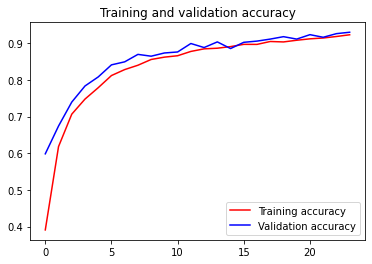

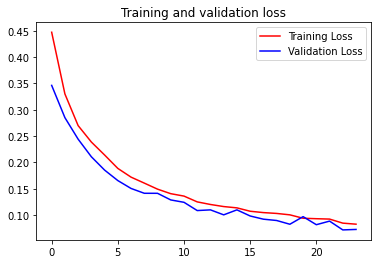

In [26]:
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
# Evaluasi model pada test set
score = model.evaluate(X_imgtest, Y_labeltest)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

72/72 [==============================] - 1s 9ms/step - loss: 17.6397 - accuracy: 0.8797
Test Loss: 17.639747619628906
Test accuracy: 0.8796662092208862


57344/56596 [==============================] - 0s 0us/step
shoes


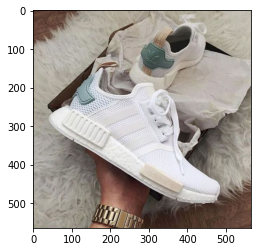

In [47]:
# load_model_sample.py
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

def load_image(img_path, show = True):
    image = mpimg.imread(img_path)
    img   = cv.resize(image, (75,75))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    if show:
      print(label_classes[np.argmax(score)])
      plt.imshow(image)
       

if __name__ == "__main__":
    img_url = "https://i.pinimg.com/564x/e8/ef/44/e8ef44546e8de77417421a760b7c5532.jpg"

    # image path
    img_path = tf.keras.utils.get_file('appa', origin=img_url)

    # load a single image
    new_image = load_image(img_path)